# Memory Information

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.58GB
Used: 597.87MB
Percentage: 3.7%


# GPU Information

In [ ]:
! nvidia-smi

Thu Aug 27 07:11:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installs, Imports, Config

In [2]:
!pip install tensorflow-gpu >> /dev/null
!pip install --upgrade grpcio >> /dev/null
!pip install tqdm  >> /dev/null
!pip install transformers >>/dev/null
!pip install h5py
#!pip uninstall Keras
#!pip install keras-applications -U
#!pip install keras-applications -U
#!pip install Keras -U

In [2]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.8.1          
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.0.1.post1    
astunparse                    1.6.3          
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.1.0         
audioread                     2.1.8          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.1.5          
blis                          0.4.1          
bokeh                         2.1.

In [3]:
import os
import pickle

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.models import load_model
#from keras.models import load_weights

import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Paths

In [4]:
distilBERTconfig = '/content/drive/My Drive/NLP_proj/distilBERT/distilbert-base-uncased-config.json'

In [5]:
train_path = "/content/drive/My Drive/NLP_proj/CSV/articles-training-bypublisher.csv"
test_path = "/content/drive/My Drive/NLP_proj/CSV/articles-validation-bypublisher.csv"
article_path = "/content/drive/My Drive/NLP_proj/CSV/articles-training-byarticle.csv"

In [6]:
byArticle_accModel = '/content/drive/My Drive/NLP_proj/Models/NEWbestAcc_byArticle_model.h5'
byArticle_lossModel = '/content/drive/My Drive/NLP_proj/Models/NEWbestLoss_byArticle_model.h5'

byPublisher_accModel = '/content/drive/My Drive/NLP_proj/Models/MIDbestAcc_byPublisher_model.h5'
byPublisher_lossModel = '/content/drive/My Drive/NLP_proj/Models/MIDbestLoss_byPublisher_model.h5'
byPublisher_fullModel = '/content/drive/My Drive/NLP_proj/Models/full_byPublisher_model.h5'

In [18]:
epochGraph_byArticle_acc_PNG = '/content/drive/My Drive/NLP_proj/Training Epoch results/NEWbyArticleACCatEPOCH.png'
epochGraph_byArticle_acc_PDF = '/content/drive/My Drive/NLP_proj/Training Epoch results/NEWbyArticleACCatEPOCH.pdf'
epochGraph_byArticle_loss_PNG = '/content/drive/My Drive/NLP_proj/Training Epoch results/NEWbyArticleLOSSatEPOCH.png'
epochGraph_byArticle_loss_PDF = '/content/drive/My Drive/NLP_proj/Training Epoch results/NEWbyArticleLOSSatEPOCH.pdf'

epochGraph_byPublisher_acc_PNG = '/content/drive/My Drive/NLP_proj/Training Epoch results/byPublisherACCatEPOCH.png'
epochGraph_byPublisher_acc_PDF = '/content/drive/My Drive/NLP_proj/Training Epoch results/byPublisherACCatEPOCH.pdf'
epochGraph_byPublisher_loss_PNG = '/content/drive/My Drive/NLP_proj/Training Epoch results/byPublisherLOSSatEPOCH.png'
epochGraph_byPublisher_loss_PDF = '/content/drive/My Drive/NLP_proj/Training Epoch results/byPublisherLOSSatEPOCH.pdf'

# Tokenization / Input IDs Functions

1. https://huggingface.co/transformers/model_doc/distilbert.html
2. https://huggingface.co/transformers/main_classes/model.html#tfpretrainedmodel
3. https://huggingface.co/transformers/model_doc/distilbert.html
4. https://www.kaggle.com/xhlulu/disaster-nlp-distilbert-in-tf/notebook?select=sample_submission.csv

In [8]:
#tokenizer = DistilBertTokenizer.from_pretrained(distilBERTconfig)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_byPublisher = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model_byArticle = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

input ID creation for sequnces longer than 512:
1. https://stackoverflow.com/questions/58636587/how-to-use-bert-for-long-text-classification
2. https://arxiv.org/pdf/1905.05583.pdf

Other transformers:
1. Longformer: https://arxiv.org/pdf/2004.05150.pdf
2. TransformerXL: https://arxiv.org/pdf/1901.02860.pdf

In [9]:
def tokenIDsale(inputarr): 
  tokenized = inputarr.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  for x in range(len(tokenized)):
    y = len(tokenized[x])
    if(y>512):
        start = tokenized[x][: 129]
        end = tokenized[x][y-383 :]
        temp = start + end
        tokenized[x] = temp

  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  return padded

# Input ID tensor creation 

## By Publisher Dataset

In [ ]:
train = pd.read_csv(train_path)

In [ ]:
%%capture
train_plainID = tokenIDsale(train['content'])
train_plainLABEL = train['truth']

In [ ]:
print("train done")

train done


In [ ]:
input_text = tf.convert_to_tensor(train_plainID)
input_label = tf.reshape(tf.constant(train_plainLABEL), (-1, 1))
#input_mask = tf.convert_to_tensor(train_plainMASK)

print("input tensor done")

input tensor done


In [ ]:
test = pd.read_csv(test_path)

In [ ]:
%%capture
test_plainID = tokenIDsale(test['content'])
test_plainLABEL = test['truth']

In [ ]:
print("test done")

test done


In [ ]:
output_text = tf.convert_to_tensor(test_plainID)
output_label = tf.reshape(tf.constant(test_plainLABEL), (-1, 1))
#output_mask = tf.convert_to_tensor(test_plainMASK)

print("output tensor done")

## ByArticle Dataset

In [10]:
article = pd.read_csv(article_path)

In [11]:
%%capture
articles_plainID = tokenIDsale(article['content'])
articles_plainLABEL = article['truth']

In [12]:
print("article done")

article done


In [13]:
articles_text = tf.convert_to_tensor(articles_plainID)
articles_label = tf.reshape(tf.constant(articles_plainLABEL), (-1, 1))

## Pickling input tensor of byPublisher Dataset  

In [10]:
#with open('/content/drive/My Drive/NLP_proj/IDandLABEL/input_text.txt', 'wb') as fh:
#  pickle.dump(input_text, fh)

#with open('/content/drive/My Drive/NLP_proj/IDandLABEL/input_label.txt', 'wb') as fh:
#  pickle.dump(input_label, fh)

#with open('/content/drive/My Drive/NLP_proj/IDandLABEL/output_text.txt', 'wb') as fh:
#  pickle.dump(output_text, fh)

#with open('/content/drive/My Drive/NLP_proj/IDandLABEL/output_label.txt', 'wb') as fh:
#  pickle.dump(output_label, fh)

In [11]:
pickle_off = open ("/content/drive/My Drive/NLP_proj/IDandLABEL/input_text.txt", "rb")
input_text = pickle.load(pickle_off)

pickle_off = open ("/content/drive/My Drive/NLP_proj/IDandLABEL/input_label.txt", "rb")
input_label = pickle.load(pickle_off)

pickle_off = open ("/content/drive/My Drive/NLP_proj/IDandLABEL/output_text.txt", "rb")
output_text = pickle.load(pickle_off)

pickle_off = open ("/content/drive/My Drive/NLP_proj/IDandLABEL/output_label.txt", "rb")
output_label = pickle.load(pickle_off)

# ByPublisher Model Training 

Terminology: https://tolotra.com/2018/07/25/what-is-the-difference-between-step-batch-size-epoch-iteration-machine-learning-terminology/

Callbacks
1. https://keras.io/api/models/model_training_apis/
2. https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html


ES callback 
1. https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
2. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
3. https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/#:~:text=During%20training%2C%20the%20model%20is,the%20training%20process%20is%20stopped.

Optimisers
1. https://www.kaggle.com/residentmario/keras-optimizers

Losses:
1. https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

Loading Weights into model:
1. https://stackoverflow.com/questions/41859997/keras-model-load-weights-for-neural-net/41860156

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=14,min_delta=0)
callback_mc_loss = tf.keras.callbacks.ModelCheckpoint(byPublisher_lossModel, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)
callback_mc_acc = tf.keras.callbacks.ModelCheckpoint(byPublisher_accModel, monitor='val_acc', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
model_byPublisher.compile(optimizer=optimizer, loss=loss,metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

NameError: ignored

In [13]:
print(len(input_text))
print(len(output_label))

600000
150000


In [14]:
history_byPublisher = model_byPublisher.fit(x= input_text, y = input_label, epochs=24, batch_size=25, steps_per_epoch=1000,
          validation_data=(output_text,output_label),validation_batch_size=25, validation_steps=400,
          use_multiprocessing = True, callbacks = [callback_mc_loss,callback_mc_acc])

Epoch 1/24
1000/1000 [==============================] - ETA: 0s - loss: 0.4663 - acc: 0.7740WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_test_batch_end` time: 0.2299s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.83108, saving model to /content/drive/My Drive/NLP_proj/Models/MIDbestLoss_byPublisher_model.h5

Epoch 00001: val_acc improved from -inf to 0.56190, saving model to /content/drive/My Drive/NLP_proj/Models/MIDbestAcc_byPublisher_model.h5
1000/1000 [==============================] - 886s 886ms/step - loss: 0.4663 - acc: 0.7740 - val_loss: 0.8311 - val_acc: 0.5619
Epoch 2/24
1000/1000 [==============================] - ETA: 0s - loss: 0.2745 - acc: 0.8846
Epoch 00002: val_loss did not improve from 0.83108

Epoch 00002: val_acc improved from 0.56190 to 0.58100, saving model to /content/drive/My Drive/NLP_proj/Models/MIDbestAcc_byPublisher_model.h5
1000/1000 [==========================

In [15]:
model_byPublisher.save_weights(byPublisher_fullModel)

In [ ]:
#_,test_acc = model.evaluate(x = output_text, y = output_label)
#print("test: ",test_acc)
#_,train_acc = model.evaluate(x = input_text, y = input_label)
#print("train: ",train_acc)

4688/4688 [==============================] - 1492s 318ms/step - loss: 1.1330 - acc: 0.5982
test:  0.5981600284576416


*   Full Model: 24epoch acc:0.6134  loss:1.0545
*   Max Accuracy:0.6134 atEpoch:24
*   Min Loss:0.83108 atEpoch:1
---



# ByPublisher Model Results

Load Weights:
1. https://stackoverflow.com/questions/41859997/keras-model-load-weights-for-neural-net/41860156

In [12]:
model_publisher_loss = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model_publisher_loss.compile(optimizer=optimizer, loss=loss,metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
model_publisher_loss.load_weights(byPublisher_lossModel)

model_publisher_acc = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model_publisher_acc.compile(optimizer=optimizer, loss=loss,metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
model_publisher_acc.load_weights(byPublisher_accModel)

model_publisher_full = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model_publisher_full.compile(optimizer=optimizer, loss=loss,metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
model_publisher_full.load_weights(byPublisher_fullModel)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [13]:
model_publisher_loss.save_pretrained("/content/drive/My Drive/NLP_proj/publisher model LOSS/")
model_publisher_acc.save_pretrained("/content/drive/My Drive/NLP_proj/publisher model ACC/")

In [19]:
_,test_acc = model_publisher_acc.evaluate(x = output_text, y = output_label)
print("byPublisher_ACC_model: ",test_acc)
_,test_acc = model_publisher_loss.evaluate(x = output_text, y = output_label)
print("byPublisher_LOSS_model: ",test_acc)
_,test_acc = model_publisher_full.evaluate(x = output_text, y = output_label)
print("byPublisher_FULL_model: ",test_acc)

4688/4688 [==============================] - 1486s 317ms/step - loss: 1.0628 - acc: 0.6119
byPublisher_ACC_model:  0.6119199991226196
4688/4688 [==============================] - 1487s 317ms/step - loss: 0.8343 - acc: 0.5561
byPublisher_LOSS_model:  0.5561333298683167
4688/4688 [==============================] - 1486s 317ms/step - loss: 1.0628 - acc: 0.6119
byPublisher_FULL_model:  0.6119199991226196


Plot loss and acc graph:
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

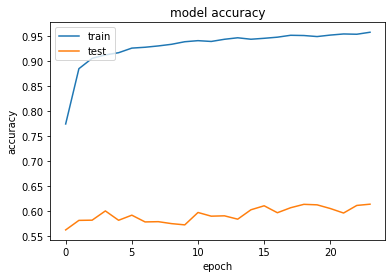

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(history_byPublisher.history['acc'])
plt.plot(history_byPublisher.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(epochGraph_byPublisher_acc_PNG)
plt.savefig(epochGraph_byPublisher_acc_PDF)

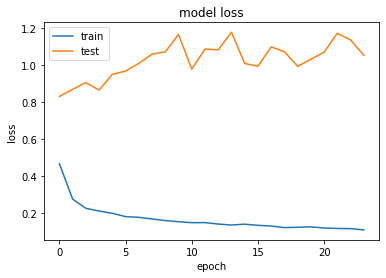

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(history_byPublisher.history['loss'])
plt.plot(history_byPublisher.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(epochGraph_byPublisher_loss_PNG)
plt.savefig(epochGraph_byPublisher_loss_PDF)

# ByArticle Model Training

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,min_delta=0)
callback_mc_loss = tf.keras.callbacks.ModelCheckpoint(byArticle_lossModel, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)
callback_mc_acc = tf.keras.callbacks.ModelCheckpoint(byArticle_accModel, monitor='val_acc', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
model_byArticle.compile(optimizer=optimizer, loss=loss,metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

In [15]:
history_byArticle = model_byArticle.fit(x= articles_text, y = articles_label, epochs=100, batch_size=20,
          validation_split=0.2,validation_batch_size=20,
          use_multiprocessing = True, callbacks = [callback_mc_loss, callback_mc_acc])

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.6776 - acc: 0.6143
Epoch 00001: val_loss improved from inf to 0.65108, saving model to /content/drive/My Drive/NLP_proj/Models/bestLoss_byArticle_model.h5

Epoch 00001: val_acc improved from -inf to 0.72093, saving model to /content/drive/My Drive/NLP_proj/Models/bestAcc_byArticle_model.h5
26/26 [==============================] - 28s 1s/step - loss: 0.6776 - acc: 0.6143 - val_loss: 0.6511 - val_acc: 0.7209
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.6599 - acc: 0.6124
Epoch 00002: val_loss improved from 0.65108 to 0.61955, saving model to /content/drive/My Drive/NLP_proj/Models/bestLoss_byArticle_model.h5

Epoch 00002: val_acc did not improve from 0.72093
26/26 [==============================] - 19s 720ms/step - loss: 0.6599 - acc: 0.6124 - val_loss: 0.6195 - val_acc: 0.7209
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.6366 - acc: 0.6105
Epoch 00003: val_loss impr

In [ ]:
#_,test_acc = model.evaluate(x = articles_text, y = articles_label)
#print("articles_ACC: ",test_acc)

21/21 [==============================] - 6s 290ms/step - loss: 0.1970 - acc: 0.9442
articles_ACC:  0.9441860318183899


*   Early Stopping at Epoch: 51
*   Max Accuracy: 0.80620  atEpoch: 36
*   Min Loss: 0.40083  atEpoch: 41

NEW
1. Max Accuracy: 0.85271 atEpoch: 89
2. Min Loss: 0.39479 atEpoch: 38

# ByArticle Model Results

In [17]:
model_article_loss = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model_article_loss.compile(optimizer=optimizer, loss=loss,metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
model_article_loss.load_weights(byArticle_lossModel)

model_article_acc = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model_article_acc.compile(optimizer=optimizer, loss=loss,metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
model_article_acc.load_weights(byArticle_accModel)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_59', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [19]:
model_article_loss.save_pretrained("/content/drive/My Drive/NLP_proj/NEW article Model LOSS/")
model_article_acc.save_pretrained("/content/drive/My Drive/NLP_proj/NEW article Model ACC/")

In [22]:
new_model = TFDistilBertForSequenceClassification.from_pretrained("/content/drive/My Drive/NLP_proj/article Model/")
new_model.compile(optimizer=optimizer, loss=loss,metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

Some weights of the model checkpoint at /content/drive/My Drive/NLP_proj/article Model/ were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/NLP_proj/article Model/ and are newly initialized: ['dropout_139']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
_,test_acc = new_model.evaluate(x = articles_text, y = articles_label)
print("new_model: ",test_acc)

21/21 [==============================] - 6s 293ms/step - loss: 0.2856 - acc: 0.8915
new_model:  0.8914728760719299


In [22]:
_,test_acc = model_article_acc.evaluate(x = articles_text, y = articles_label)
print("articles_ACC_model: ",test_acc)
_,test_acc = model_article_loss.evaluate(x = articles_text, y = articles_label)
print("articles_LOSS_model: ",test_acc)

21/21 [==============================] - 6s 291ms/step - loss: 0.1358 - acc: 0.9659
articles_ACC_model:  0.9658914804458618
21/21 [==============================] - 6s 292ms/step - loss: 0.2300 - acc: 0.9302
articles_LOSS_model:  0.930232584476471


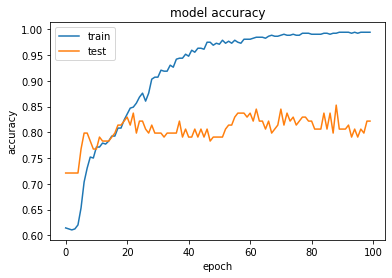

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(history_byArticle.history['acc'])
plt.plot(history_byArticle.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(epochGraph_byArticle_acc_PNG)
plt.savefig(epochGraph_byArticle_acc_PDF)

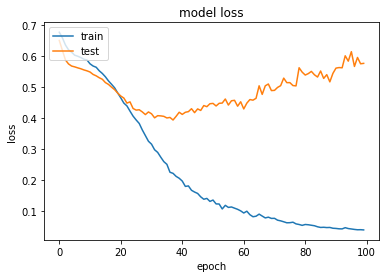

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(history_byArticle.history['loss'])
plt.plot(history_byArticle.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(epochGraph_byArticle_loss_PNG)
plt.savefig(epochGraph_byArticle_loss_PDF)